In [3]:
# imports
import ipdb, os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Switch context

In [4]:
path_to_source = f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/pwc_ibm_150_5_10_10000/10Neg10000unk/twofoldwithunk"
path_to_clone = f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/pwc_latex_text/pwc_latex_5_10_10000/twofoldwithunk"
# path_to_source = f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/pwc_latex_text/pwc_latex_5_10_10000_clone/twofoldwithunk"
# path_to_clone = f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/pwc_ibm_150_5_10_10000/10Neg10000unk/twofoldwithunk"

In [5]:
fold = "fold1"
train_source_pd = pd.read_csv(f"{path_to_source}/{fold}/train.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

dev_source_pd = pd.read_csv(f"{path_to_source}/{fold}/dev.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])


train_clone_pd = pd.read_csv(f"{path_to_clone}/{fold}/train.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

dev_clone_pd = pd.read_csv(f"{path_to_clone}/{fold}/dev.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [6]:
train_source_pd.tail()

,label,title,TDM,Context
38702,False,1909.09051v1.pdf,word_segmentation; VLSP 2013 word segmentation...,Self-Supervised Monocular Depth Hints Monocula...
38703,False,1909.09051v1.pdf,Sentiment Analysis; SST-5 Fine-grained classif...,Self-Supervised Monocular Depth Hints Monocula...
38704,False,1909.09051v1.pdf,3D Object Detection; nuScenes; NDS,Self-Supervised Monocular Depth Hints Monocula...
38705,False,1909.09051v1.pdf,Birds Eye View Object Detection; KITTI Cars Ea...,Self-Supervised Monocular Depth Hints Monocula...
38706,False,1909.09051v1.pdf,Node Classification; Wisconsin; Accuracy,Self-Supervised Monocular Depth Hints Monocula...


In [7]:
train_clone_pd.tail()

,label,title,TDM,Context
50138,False,1909.09051v1.pdf,word_segmentation; VLSP 2013 word segmentation...,Self-Supervised Monocular Depth Hints Monocula...
50139,False,1909.09051v1.pdf,Sentiment Analysis; SST-5 Fine-grained classif...,Self-Supervised Monocular Depth Hints Monocula...
50140,False,1909.09051v1.pdf,3D Object Detection; nuScenes; NDS,Self-Supervised Monocular Depth Hints Monocula...
50141,False,1909.09051v1.pdf,Birds Eye View Object Detection; KITTI Cars Ea...,Self-Supervised Monocular Depth Hints Monocula...
50142,False,1909.09051v1.pdf,Node Classification; Wisconsin; Accuracy,Self-Supervised Monocular Depth Hints Monocula...


### train_IBM_pd vs trainOutput_150_IBM_pd

In [8]:
train_source_pd[train_source_pd.label==True].head()

,label,title,TDM,Context
0,True,1707.03497v2.pdf,Atari Games; Atari 2600 Seaquest; Score,Value Prediction Network This paper proposes a...
1,True,1707.03497v2.pdf,Atari Games; Atari 2600 Amidar; Score,Value Prediction Network This paper proposes a...
2,True,1707.03497v2.pdf,Atari Games; Atari 2600 Krull; Score,Value Prediction Network This paper proposes a...
3,True,1707.03497v2.pdf,Atari Games; Atari 2600 Alien; Score,Value Prediction Network This paper proposes a...
4,True,1707.03497v2.pdf,Atari Games; Atari 2600 Enduro; Score,Value Prediction Network This paper proposes a...


In [9]:
# List of pdf name that are in the test file
list_train_source_pd_uniq = list(train_source_pd.title.unique())
len(list_train_source_pd_uniq)

2876

In [10]:
# List of pdf name that are in the train file
list_dev_source_pd_uniq = list(dev_source_pd.title.unique())
len(list_dev_source_pd_uniq)

1219

In [11]:
# total number of uniq pdf in the train and testing
len(list_train_source_pd_uniq)+len(list_dev_source_pd_uniq)

4095

In [12]:
# List of pdf name that are in the train file
list_train_clone_pd_uniq = list(train_clone_pd.title.unique())
len(list_train_clone_pd_uniq)

3753

In [13]:
# List of pdf name that are in the train file
list_dev_clone_pd_uniq = list(dev_clone_pd.title.unique())
len(list_dev_clone_pd_uniq)

1608

In [14]:
# total number of uniq pdf in the train and testing
len(list_train_clone_pd_uniq)+len(list_dev_clone_pd_uniq)

5361

In [15]:
# Dict to contains new context

dict_train_source_paper_context = {}
for paper in list_train_source_pd_uniq:
    dict_train_source_paper_context[paper]=train_source_pd[train_source_pd.title==paper].Context.values[0]
for paper in list_dev_source_pd_uniq:
    dict_train_source_paper_context[paper]=dev_source_pd[dev_source_pd.title==paper].Context.values[0]
    
dict_train_clone_paper_context = {}
for paper in list_train_clone_pd_uniq:
    dict_train_clone_paper_context[paper]=train_clone_pd[train_clone_pd.title==paper].Context.values[0]
for paper in list_dev_clone_pd_uniq:
    dict_train_clone_paper_context[paper]=dev_clone_pd[dev_clone_pd.title==paper].Context.values[0]

In [16]:
def get_start_lenght(dictionary, limit="150", title="",):
    # Stats
    len_context= []
    for context in dictionary.values():
        len_context.append(len(context.split()))
    
    print(f"Context TDM limit {limit}:")
    print(f"Mean lenght: {np.mean(len_context)}")
    print(f"Max lenght: {np.max(len_context)}")
    print(f"Min lenght: {np.min(len_context)}")
    print(f"Std lenght: {np.std(len_context)}")
    
    x = np.arange(1, len(len_context)+1, 1)
    y = len_context

    plt.plot(x, y)

    plt.title(title)
    plt.xlabel("number of papers")
    plt.ylabel("lenght DocTAET")
    plt.savefig(fname=re.sub(r"[0-9]+", '', title).strip())
    plt.show()
    
    return len_context

Context TDM limit None:
Mean lenght: 734.1008547008547
Max lenght: 7374
Min lenght: 1
Std lenght: 448.97058088734724


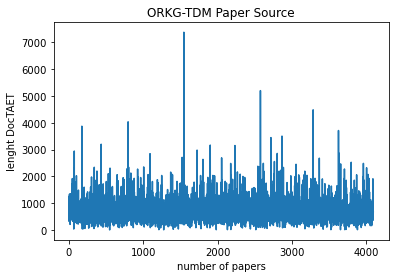

In [17]:
len_context_150 = get_start_lenght(dict_train_source_paper_context, 
                                   limit="None", 
                                   title="ORKG-TDM Paper Source")

Context TDM limit None:
Mean lenght: 378.88919977616115
Max lenght: 2161
Min lenght: 5
Std lenght: 119.6318828220644


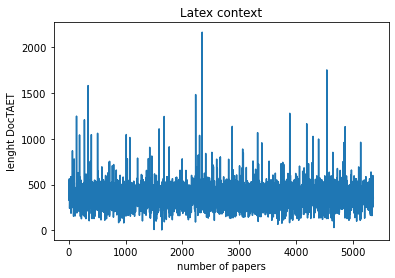

In [18]:
len_context_150 = get_start_lenght(dict_train_clone_paper_context, 
                                   limit="None", 
                                   title="Latex context")

In [19]:
dict_train_source_paper_context["1301.3592v6.pdf"]

'Deep Learning for Detecting Robotic Grasps We consider the problem of detecting robotic grasps in an RGB-D\xa0view of a scene containing objects. In this work, we apply a deep learning approach to solve this problem, which avoids time-consuming hand-design of features. This presents two main challenges. First, we need to evaluate a huge number of candidate grasps. In order to make detection fast and robust, we present a two-step cascaded system with two deep networks, where the top detections from the first are re-evaluated by the second. The first network has fewer features, is faster to run, and can effectively prune out unlikely candidate grasps. The second, with more features, is slower but has to run only on the top few detections. Second, we need to handle multimodal inputs effectively, for which we present a method that applies structured regularization on the weights based on multimodal group regularization. We show that our method improves performance on an RGBD robotic grasp

In [20]:
dict_train_clone_paper_context["1301.3592v6.pdf"]

'Deep Learning for Detecting Robotic Grasps We consider the problem of detecting robotic grasps in an RGB-D view of a scene containing objects. In this work, we apply a deep learning approach to solve this problem, which avoids time-consuming hand-design of features. This presents two main challenges. First, we need to evaluate a huge number of candidate grasps. In order to make detection fast and robust, we present a two-step cascaded system with two deep networks, where the top detections from the first are re-evaluated by the second. The first network has fewer features, is faster to run, and can effectively prune out unlikely candidate grasps. The second, with more features, is slower but has to run only on the top few detections. Second, we need to handle multimodal inputs effectively, for which we present a method that applies structured regularization on the weights based on multimodal group regularization. We show that our method improves performance on an RGBD robotic grasping

In [21]:
# train_source_pd["Context"] = train_source_pd.apply(lambda x : dict_train_clone_paper_context[x['title']] if x['title'] in dict_train_clone_paper_context.keys() else "None", axis=1)
# train_source_pd.drop(train_source_pd.index[train_source_pd['Context'] == 'None'], inplace = True)
# dev_source_pd["Context"] = dev_source_pd.apply(lambda x : dict_train_clone_paper_context[x['title']] if x['title'] in dict_train_clone_paper_context.keys() else "None", axis=1)
# dev_source_pd.drop(dev_source_pd.index[dev_source_pd['Context'] == 'None'], inplace = True)

In [45]:
# List of pdf name that are in the test file
list_train_source_pd_uniq = list(train_source_pd.title.unique())
len(list_train_source_pd_uniq)

2881

In [46]:
# List of pdf name that are in the train file
list_dev_source_pd_uniq = list(dev_source_pd.title.unique())
len(list_dev_source_pd_uniq)

1214

In [47]:
dict_train_source_paper_context = {}
for paper in list_train_source_pd_uniq:
    dict_train_source_paper_context[paper]=train_source_pd[train_source_pd.title==paper].Context.values[0]
for paper in list_dev_source_pd_uniq:
    dict_train_source_paper_context[paper]=dev_source_pd[dev_source_pd.title==paper].Context.values[0]

Context TDM limit None:
Mean lenght: 734.1008547008547
Max lenght: 7374
Min lenght: 1
Std lenght: 448.97058088734724


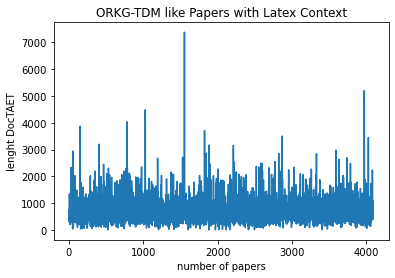

In [48]:
len_context_150 = get_start_lenght(dict_train_source_paper_context, 
                                   limit="None", 
                                   title="ORKG-TDM like Papers with Latex Context")

In [49]:
path_to_clone = f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/pwc_latex_text/pwc_latex_5_10_10000/twofoldwithunk"
new_path = f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/pwc_latex_text/pwc_latex_5_10_10000_clone/twofoldwithunk/{fold}"
os.makedirs(new_path) if not os.path.exists(new_path) else "Pass"


                              
train_source_pd.to_csv(path_or_buf=f"{new_path}/train.tsv", 
                 sep="\t", header=None, index=False)

dev_source_pd.to_csv(path_or_buf=f"{new_path}/dev.tsv", 
                 sep="\t", header=None, index=False)

### Zero-shot

In [145]:
train_IBM_zero_shot_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/zero-shot-setup/NLP-TDMS/train.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

test_IBM_zero_shot_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/zero-shot-setup/NLP-TDMS/test.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])


trainOutput_150_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/IBM_jar_150/0Neg1000unk/trainOutput.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

trainOutput_full_IBM_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/IBM_jar_full/0Neg1000unk/trainOutput.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [150]:
# List of pdf name that are in the test file
list_train_IBM_zero_shot_uniq = list(train_IBM_zero_shot_pd.title.unique())
len(list_train_IBM_zero_shot_uniq)

210

In [151]:
# List of pdf name that are in the train file
list_test_IBM_zero_shot_uniq = list(test_IBM_zero_shot_pd.title.unique())
len(list_test_IBM_zero_shot_uniq)

108

In [152]:
# # Dict to contain new context
# dict_150_paper_zero_shot_context = {}
# for paper in list_trainOutput_150_IBM_pd_uniq:
#     dict_150_paper_context[paper]=trainOutput_150_IBM_pd[trainOutput_150_IBM_pd.title==paper].Context.values[0]
    
dict_original_paper_zero_shot_context = {}
for paper in list_train_IBM_zero_shot_uniq:
    dict_original_paper_zero_shot_context[paper]=train_IBM_zero_shot_pd[train_IBM_zero_shot_pd.title==paper].Context.values[0]
for paper in list_test_IBM_zero_shot_uniq:
    dict_original_paper_zero_shot_context[paper]=test_IBM_zero_shot_pd[test_IBM_zero_shot_pd.title==paper].Context.values[0]

In [154]:
len_context_original_zero_shot = get_start_lenght(dict_original_paper_zero_shot_context, limit="IBM Original Zero-shot")

Context TDM limit IBM Original Zero-shot:
Mean lenght: 309.7295597484277
Max lenght: 546
Min lenght: 81
Std lenght: 93.96825943002948


In [155]:
train_IBM_zero_shot_pd["Context"] = train_IBM_zero_shot_pd.apply(lambda x : dict_full_paper_context[x['title']] if x['title'] in dict_full_paper_context.keys() else "None", axis=1)
test_IBM_zero_shot_pd["Context"] = test_IBM_zero_shot_pd.apply(lambda x : dict_full_paper_context[x['title']] if x['title'] in dict_full_paper_context.keys() else "None", axis=1)

In [157]:
# Verification
dict_original_paper_zero_shot_context = {}
for paper in list_train_IBM_zero_shot_uniq:
    dict_original_paper_zero_shot_context[paper]=train_IBM_zero_shot_pd[train_IBM_zero_shot_pd.title==paper].Context.values[0]
for paper in list_test_IBM_zero_shot_uniq:
    dict_original_paper_zero_shot_context[paper]=test_IBM_zero_shot_pd[test_IBM_zero_shot_pd.title==paper].Context.values[0]
    
len_context_original_zero_shot = get_start_lenght(dict_original_paper_zero_shot_context, limit="IBM Original Zero-shot extended")

Context TDM limit IBM Original Zero-shot extended:
Mean lenght: 372.1383647798742
Max lenght: 1220
Min lenght: 81
Std lenght: 170.48358809915555


In [164]:
path_train_full = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train_full.tsv"
path_test_full = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test_full.tsv"

train_IBM_pd.to_csv(path_or_buf=path_train_full, 
                 sep="\t", header=None, index=False)

test_IBM_pd.to_csv(path_or_buf=path_test_full, 
                 sep="\t", header=None, index=False)

### ARC-PDN

In [173]:
train_IBM_ARC_PDN_pd = pd.read_csv(f"/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/ARC-PDN/test_pdn.tsv", 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [174]:
train_IBM_ARC_PDN_pd.tail()

,label,title,TDM,Context
304540,True,N10-3003.pdf,"dependency parsing, Penn Treebank, LAS",Detecting Novelty in the context of Progressiv...
304541,True,N10-3003.pdf,"language modeling, Hutter Prize, Number of params",Detecting Novelty in the context of Progressiv...
304542,True,N10-3003.pdf,"summarization, CNN / Daily Mail (Non-anonymize...",Detecting Novelty in the context of Progressiv...
304543,True,N10-3003.pdf,"word sense disambiguation, Senseval 3, F1",Detecting Novelty in the context of Progressiv...
304544,True,N10-3003.pdf,"text classification, TREC, Error",Detecting Novelty in the context of Progressiv...


In [175]:
# List of pdf name that are in the test file
list_train_IBM_ARC_PDN_pd_uniq = list(train_IBM_ARC_PDN_pd.title.unique())
len(list_train_IBM_ARC_PDN_pd_uniq)

3855

In [176]:
# # Dict to contain new context
# dict_150_paper_zero_shot_context = {}
# for paper in list_trainOutput_150_IBM_pd_uniq:
#     dict_150_paper_context[paper]=trainOutput_150_IBM_pd[trainOutput_150_IBM_pd.title==paper].Context.values[0]
    
dict_original_IBM_ARC_PDN_context = {}
for paper in list_train_IBM_ARC_PDN_pd_uniq:
    dict_original_IBM_ARC_PDN_context[paper]=train_IBM_ARC_PDN_pd[train_IBM_ARC_PDN_pd.title==paper].Context.values[0]

In [177]:
len_context_original_ARC_PDN = get_start_lenght(dict_original_IBM_ARC_PDN_context, limit="IBM Original ARC-PDN")

Context TDM limit IBM Original ARC-PDN:
Mean lenght: 254.063813229572
Max lenght: 2198
Min lenght: 0
Std lenght: 111.35486130695618


In [183]:
len(train_IBM_ARC_PDN_pd.Context.values[0].split())

57

In [190]:
train_IBM_ARC_PDN_pd[train_IBM_ARC_PDN_pd.Context == " "].head()

,label,title,TDM,Context


In [171]:
train_IBM_ARC_PDN_pd["Context"] = train_IBM_ARC_PDN_pd.apply(lambda x : dict_full_paper_context[x['title']] if x['title'] in dict_full_paper_context.keys() else "None", axis=1)
# test_IBM_zero_shot_pd["Context"] = test_IBM_zero_shot_pd.apply(lambda x : dict_full_paper_context[x['title']] if x['title'] in dict_full_paper_context.keys() else "None", axis=1)

In [172]:
dict_original_IBM_ARC_PDN_context = {}
for paper in list_train_IBM_ARC_PDN_pd_uniq:
    dict_original_IBM_ARC_PDN_context[paper]=train_IBM_ARC_PDN_pd[train_IBM_ARC_PDN_pd.title==paper].Context.values[0]
    
len_context_original_ARC_PDN = get_start_lenght(dict_original_IBM_ARC_PDN_context, limit="IBM Original ARC-PDN")

Context TDM limit IBM Original ARC-PDN:
Mean lenght: 2.6684824902723734
Max lenght: 631
Min lenght: 1
Std lenght: 24.29166868448258


In [164]:
path_train_full = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train_full.tsv"
path_test_full = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test_full.tsv"

train_IBM_pd.to_csv(path_or_buf=path_train_full, 
                 sep="\t", header=None, index=False)

test_IBM_pd.to_csv(path_or_buf=path_test_full, 
                 sep="\t", header=None, index=False)

In [ ]:
# Big dataset problematic resources 

# Max lenght exceed 10000 Grobid limit
Processing file: /nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1810.06682v2.pdf
        
    
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1504.08200.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1907.09665v10.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/2002.02050v3.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/2002.02050v3.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1911.10807v3.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1909.13476v1.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1711.07566v1.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/download_pdfs.py
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1804.01508v10.pdf
/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1812.01527v2.pdf

In [78]:
!mv /nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/download_pdfs.py /nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/download_pdfs_2.py

In [90]:
# !rm /nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1810.06682v2.pdf

rm: cannot remove '/nfs/home/kabenamualus/Research/task-dataset-metric-extraction/data/pdf_IBM/1810.06682v2.pdf': No such file or directory


## Create data stats visualization

In [46]:
IBM_train_csv = "~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train.tsv"
IBM_test_csv = "~/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test.tsv"

IBM_train_full_csv = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/train_full.tsv"
IBM_test_full_csv = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/ibm/exp/few-shot-setup/NLP-TDMS/paperVersion/test_full.tsv"

In [47]:
train_IBM = pd.read_csv(IBM_train_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

train_full_IBM = pd.read_csv(IBM_train_full_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

# test_IBM = pd.read_csv(IBM_test_csv, 
#                     sep="\t", names=["label", "title", "TDM", "Context"])

In [48]:
train_IBM[(train_IBM.label==True) & (train_IBM.TDM!="unknown")].head(30)

,label,title,TDM,Context
316,True,1602.02373.pdf,text classification; DBpedia; Error,Supervised and Semi-Supervised Text Categoriza...
317,True,1602.02373.pdf,sentiment analysis; IMDb; Accuracy,Supervised and Semi-Supervised Text Categoriza...
318,True,1602.02373.pdf,text classification; AG News; Error,Supervised and Semi-Supervised Text Categoriza...
394,True,1603.01547.pdf,question answering; SearchQA; N-gram F1,Text Understanding with the Attention Sum Read...
395,True,1603.01547.pdf,question answering; SearchQA; Unigram Acc,Text Understanding with the Attention Sum Read...
472,True,C16-1119.pdf,relationship extraction; SemEval-2010 Task 8; F1,Semantic Relation Classification via Hierarchi...
708,True,P16-1085.pdf,word sense disambiguation; SemEval 2013; F1,Embeddings for Word Sense Disambiguation: An E...
709,True,P16-1085.pdf,word sense disambiguation; SemEval 2015; F1,Embeddings for Word Sense Disambiguation: An E...
710,True,P16-1085.pdf,word sense disambiguation; Senseval 2; F1,Embeddings for Word Sense Disambiguation: An E...
711,True,P16-1085.pdf,word sense disambiguation; Senseval 3; F1,Embeddings for Word Sense Disambiguation: An E...


In [49]:
selected_paper = "D17-1222.pdf"

In [50]:
train_IBM[(train_IBM.label==True) & (train_IBM.title==selected_paper)].tail(20)

,label,title,TDM,Context
1646,True,D17-1222.pdf,summarization; DUC 2004 Task 1; ROUGE-L,Deep Recurrent Generative Decoder for Abstract...
1647,True,D17-1222.pdf,summarization; Gigaword; ROUGE-1,Deep Recurrent Generative Decoder for Abstract...
1648,True,D17-1222.pdf,summarization; DUC 2004 Task 1; ROUGE-1,Deep Recurrent Generative Decoder for Abstract...
1649,True,D17-1222.pdf,summarization; DUC 2004 Task 1; ROUGE-2,Deep Recurrent Generative Decoder for Abstract...
1650,True,D17-1222.pdf,summarization; Gigaword; ROUGE-L,Deep Recurrent Generative Decoder for Abstract...
1651,True,D17-1222.pdf,summarization; Gigaword; ROUGE-2,Deep Recurrent Generative Decoder for Abstract...


In [51]:
train_IBM[train_IBM.title==selected_paper].Context.values[0]

'Deep Recurrent Generative Decoder for Abstractive Text Summarization * We propose anew framework for ab-stractive text summarization based on a sequence-to-sequence oriented encoder-decoder model equipped with a deep recurrent generative decoder (DRGN). Latent structure information implied in the target summaries is learned based on a recurrent latent random model for improving the summarization quality. Neural variational inference is employed to address the intractable posterior inference for the recurrent latent variables. Abstractive summaries are generated based on both the generative latent variables and the dis-criminative deterministic states. Extensive experiments on some benchmark datasets in different languages show that DRGN achieves improvements over the state-of-the-art methods. We use ROUGE score) as our evaluation metric with standard options For the experiments on the English dataset Gigawords, we set the dimension of word embeddings to 300, and the dimension of hidde

In [52]:
train_full_IBM[train_full_IBM.title==selected_paper].Context.values[0]

'Deep Recurrent Generative Decoder for Abstractive Text Summarization * We propose anew framework for ab-stractive text summarization based on a sequence-to-sequence oriented encoder-decoder model equipped with a deep recurrent generative decoder (DRGN). Latent structure information implied in the target summaries is learned based on a recurrent latent random model for improving the summarization quality. Neural variational inference is employed to address the intractable posterior inference for the recurrent latent variables. Abstractive summaries are generated based on both the generative latent variables and the dis-criminative deterministic states. Extensive experiments on some benchmark datasets in different languages show that DRGN achieves improvements over the state-of-the-art methods. We use ROUGE score) as our evaluation metric with standard options For the experiments on the English dataset Gigawords, we set the dimension of word embeddings to 300, and the dimension of hidde

## Check that the newly generated data doesnt link

In [2]:
PWC_train_csv = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/pwc_ibm_150_5_10_800/twofoldwithunk/fold1/train.tsv"
PWC_valid_csv = "/nfs/home/kabenamualus/Research/task-dataset-metric-nli-extraction/data/pwc_ibm_150_5_10_800/twofoldwithunk/fold1/dev.tsv"

train_PWC = pd.read_csv(PWC_train_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

valid_PWC = pd.read_csv(PWC_valid_csv, 
                    sep="\t", names=["label", "title", "TDM", "Context"])

In [8]:
train_PWC[train_PWC.label==True].title.unique()

array(['1707.03497v2.pdf', 'P18-1063.pdf', '2006.10721v2.pdf', ...,
       '1411.1091v1.pdf', '1912.04799v2.pdf', '1307.0414v1.pdf'],
      dtype=object)

In [20]:
set_train_unique = set(train_PWC[train_PWC.label==True].title.unique())
set_valid_unique = set(valid_PWC[valid_PWC.label==True].title.unique())

In [21]:
duplicate = []
for paper in set_train_unique:
    if paper in set_valid_unique:
        duplicate.append(paper)

In [22]:
len(duplicate)

0

In [23]:
len(set_train_unique)

3181

In [24]:
len(set_valid_unique)

1361

In [25]:
duplicate = []
for paper in set_valid_unique:
    if paper in set_train_unique:
        duplicate.append(paper)

In [26]:
len(duplicate)

0